#### objective
1. understand algo
2. re-read paper and understand "online-training" and other technical nuances
3. think about data
4. (optional) set up AWS
5. (optional) backtester

In [28]:
import numpy as np
import pandas as pd
# import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import matplotlib.pyplot as plt
import seaborn as sns
# from tensorflow.python.framework import ops
tf.disable_v2_behavior()
sns.set()

In [29]:
df_hsi = pd.read_csv('^HSI.csv')[['Date', 'Adj Close']]
df_spx = pd.read_csv('^GSPC.csv')[['Date', 'Adj Close']]
df_hsi.rename(columns={'Adj Close':'hsi'}, inplace=True)
df_spx.rename(columns={'Adj Close':'spx'}, inplace=True)
df = df_hsi.merge(df_spx, on='Date').dropna()

In [30]:
df = pd.read_csv('^GSPC.csv')[['Date', 'Close']]
df

,Date,Close
0,2001-01-02,1283.270020
1,2001-01-03,1347.560059
2,2001-01-04,1333.339966
3,2001-01-05,1298.349976
4,2001-01-08,1295.859985
...,...,...
3768,2015-12-24,2060.989990
3769,2015-12-28,2056.500000
3770,2015-12-29,2078.360107
3771,2015-12-30,2063.360107


In [31]:
from collections import deque
import random


class Agent:
    def __init__(self, state_size, window_size, trend, skip, batch_size):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.action_size = 3
        self.batch_size = batch_size
        self.memory = deque(maxlen = 1000)
        self.inventory = []

        self.gamma = 0.95
        self.epsilon = 0.5
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999

        tf.reset_default_graph()
        self.sess = tf.InteractiveSession()
        self.X = tf.placeholder(tf.float32, [None, self.state_size])
        self.Y = tf.placeholder(tf.float32, [None, self.action_size])
        feed = tf.layers.dense(self.X, 256, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed, self.action_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.GradientDescentOptimizer(1e-5).minimize(
            self.cost
        )
        self.sess.run(tf.global_variables_initializer())

    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        return np.argmax(
            self.sess.run(self.logits, feed_dict = {self.X: state})[0] # pick action that maximizes logits (through forward pass)
        )
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])

    def replay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size, l):
            mini_batch.append(self.memory[i])
        replay_size = len(mini_batch)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.action_size))
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        Q = self.sess.run(self.logits, feed_dict = {self.X: states})
        Q_new = self.sess.run(self.logits, feed_dict = {self.X: new_states})
        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            target[action] = reward
            if not done:
                target[action] += self.gamma * np.amax(Q_new[i])
            X[i] = state
            Y[i] = target
        cost, _ = self.sess.run(
            [self.cost, self.optimizer], feed_dict = {self.X: X, self.Y: Y}
        )
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return cost
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
                
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
        
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(state)
                next_state = self.get_state(t + 1)
                
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                    
                invest = ((starting_money - initial_money) / initial_money)
                self.memory.append((state, action, invest, 
                                    next_state, starting_money < initial_money))
                state = next_state
                batch_size = min(self.batch_size, len(self.memory))
                cost = self.replay(batch_size)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [ ]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)
agent.train(iterations = 1000, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: 1834.437592.3, cost: 0.895270, total money: 11834.437592
epoch: 20, total rewards: 2796.128938.3, cost: 0.638386, total money: 12796.128938
epoch: 30, total rewards: 2445.088467.3, cost: 0.331469, total money: 12445.088467
epoch: 40, total rewards: 3385.508822.3, cost: 0.262817, total money: 13385.508822
epoch: 50, total rewards: 2606.938386.3, cost: 0.191249, total money: 12606.938386
epoch: 60, total rewards: 1928.438746.3, cost: 0.168297, total money: 11928.438746
epoch: 70, total rewards: 2132.628874.3, cost: 0.130826, total money: 12132.628874
epoch: 80, total rewards: 1820.618074.3, cost: 0.105027, total money: 11820.618074
epoch: 90, total rewards: 2353.718782.3, cost: 0.331270, total money: 12353.718782
epoch: 100, total rewards: 2361.038114.3, cost: 0.101765, total money: 12361.038114
epoch: 110, total rewards: 1912.047824.3, cost: 0.075510, total money: 11912.047824
epoch: 120, total rewards: 1620.488068.3, cost: 0.124818, total money: 11620.488068
e

In [21]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 5: buy 1 unit at price 1300.800049, total balance 8699.199951
day 7: buy 1 unit at price 1326.819946, total balance 7372.380005
day 8: buy 1 unit at price 1318.550049, total balance 6053.829956
day 10, sell 1 unit at price 1329.469971, investment 2.204022 %, total balance 7383.299927,
day 11, sell 1 unit at price 1347.969971, investment 1.594039 %, total balance 8731.269898,
day 16, sell 1 unit at price 1357.510010, investment 2.954758 %, total balance 10088.779908,
day 29: buy 1 unit at price 1318.800049, total balance 8769.979859
day 30, sell 1 unit at price 1315.920044, investment -0.218381 %, total balance 10085.899903,
day 35: buy 1 unit at price 1252.819946, total balance 8833.079957
day 37: buy 1 unit at price 1267.650024, total balance 7565.429933
day 38, sell 1 unit at price 1257.939941, investment 0.408678 %, total balance 8823.369874,
day 39: buy 1 unit at price 1239.939941, total balance 7583.429933
day 40: buy 1 unit at price 1241.229980, total balance 6342.199953
day 

day 472: buy 1 unit at price 914.150024, total balance 8654.499757
day 473, sell 1 unit at price 933.760010, investment 2.145161 %, total balance 9588.259767,
day 479: buy 1 unit at price 934.530029, total balance 8653.729738
day 481, sell 1 unit at price 917.580017, investment -1.813747 %, total balance 9571.309755,
day 489: buy 1 unit at price 910.400024, total balance 8660.909731
day 490, sell 1 unit at price 902.989990, investment -0.813932 %, total balance 9563.899721,
day 498: buy 1 unit at price 879.390015, total balance 8684.509706
day 499: buy 1 unit at price 879.820007, total balance 7804.689699
day 500, sell 1 unit at price 909.030029, investment 3.370520 %, total balance 8713.719728,
day 501: buy 1 unit at price 908.590027, total balance 7805.129701
day 502, sell 1 unit at price 929.010010, investment 5.590917 %, total balance 8734.139711,
day 503, sell 1 unit at price 922.929993, investment 1.578266 %, total balance 9657.069704,
day 511: buy 1 unit at price 901.780029, tot

day 881: buy 1 unit at price 1112.810059, total balance 8498.669867
day 882, sell 1 unit at price 1114.349976, investment 0.138381 %, total balance 9613.019843,
day 884: buy 1 unit at price 1111.469971, total balance 8501.549872
day 886: buy 1 unit at price 1101.390015, total balance 7400.159857
day 887, sell 1 unit at price 1100.900024, investment -0.950988 %, total balance 8501.059881,
day 888: buy 1 unit at price 1108.670044, total balance 7392.389837
day 889, sell 1 unit at price 1093.880005, investment -0.681867 %, total balance 8486.269842,
day 890, sell 1 unit at price 1096.839966, investment -1.067051 %, total balance 9583.109808,
day 903: buy 1 unit at price 1079.040039, total balance 8504.069769
day 905: buy 1 unit at price 1063.229980, total balance 7440.839789
day 906, sell 1 unit at price 1064.800049, investment -1.319691 %, total balance 8505.639838,
day 907, sell 1 unit at price 1079.339966, investment 1.515193 %, total balance 9584.979804,
day 919: buy 1 unit at price 1

day 1365: buy 1 unit at price 1252.300049, total balance 7254.249577
day 1366: buy 1 unit at price 1237.439941, total balance 6016.809636
day 1367, sell 1 unit at price 1223.689941, investment -2.721941 %, total balance 7240.499577,
day 1368: buy 1 unit at price 1230.040039, total balance 6010.459538
day 1371, sell 1 unit at price 1240.130005, investment -0.971815 %, total balance 7250.589543,
day 1372, sell 1 unit at price 1240.119995, investment 0.216581 %, total balance 8490.709538,
day 1374: buy 1 unit at price 1245.599976, total balance 7245.109562
day 1375, sell 1 unit at price 1244.500000, investment 1.175568 %, total balance 8489.609562,
day 1376: buy 1 unit at price 1250.560059, total balance 7239.049503
day 1377, sell 1 unit at price 1239.199951, investment -0.513811 %, total balance 8478.249454,
day 1378: buy 1 unit at price 1246.000000, total balance 7232.249454
day 1379, sell 1 unit at price 1272.869995, investment 1.783996 %, total balance 8505.119449,
day 1380: buy 1 uni

day 1858: buy 1 unit at price 1385.349976, total balance 8368.789248
day 1859, sell 1 unit at price 1390.839966, investment 0.396289 %, total balance 9759.629214,
day 1861: buy 1 unit at price 1400.380005, total balance 8359.249209
day 1862, sell 1 unit at price 1385.670044, investment -1.050426 %, total balance 9744.919253,
day 1864: buy 1 unit at price 1377.199951, total balance 8367.719302
day 1865, sell 1 unit at price 1404.050049, investment 1.949615 %, total balance 9771.769351,
day 1872: buy 1 unit at price 1360.140015, total balance 8411.629336
day 1874, sell 1 unit at price 1337.810059, investment -1.641740 %, total balance 9749.439395,
day 1878: buy 1 unit at price 1314.290039, total balance 8435.149356
day 1880, sell 1 unit at price 1283.150024, investment -2.369341 %, total balance 9718.299380,
day 1887: buy 1 unit at price 1273.699951, total balance 8444.599429
day 1888, sell 1 unit at price 1244.689941, investment -2.277617 %, total balance 9689.289370,
day 1893: buy 1 un

day 2331: buy 1 unit at price 1197.300049, total balance 7986.488769
day 2332, sell 1 unit at price 1210.650024, investment 1.115007 %, total balance 9197.138793,
day 2336: buy 1 unit at price 1207.170044, total balance 7989.968749
day 2337, sell 1 unit at price 1205.939941, investment -0.101900 %, total balance 9195.908690,
day 2339: buy 1 unit at price 1217.280029, total balance 7978.628661
day 2340, sell 1 unit at price 1212.050049, investment -0.429645 %, total balance 9190.678710,
day 2342: buy 1 unit at price 1191.359985, total balance 7999.318725
day 2343, sell 1 unit at price 1206.780029, investment 1.294323 %, total balance 9206.098754,
day 2346: buy 1 unit at price 1173.599976, total balance 8032.498778
day 2348, sell 1 unit at price 1128.150024, investment -3.872695 %, total balance 9160.648802,
day 2361: buy 1 unit at price 1074.030029, total balance 8086.618773
day 2362, sell 1 unit at price 1067.949951, investment -0.566099 %, total balance 9154.568724,
day 2364: buy 1 un

day 2802: buy 1 unit at price 1363.459961, total balance 7863.648801
day 2803, sell 1 unit at price 1365.739990, investment 0.167224 %, total balance 9229.388791,
day 2815: buy 1 unit at price 1395.949951, total balance 7833.438840
day 2816, sell 1 unit at price 1394.280029, investment -0.119626 %, total balance 9227.718869,
day 2842: buy 1 unit at price 1378.530029, total balance 7849.188840
day 2846: buy 1 unit at price 1399.979980, total balance 6449.208860
day 2850, sell 1 unit at price 1402.310059, investment 1.725028 %, total balance 7851.518919,
day 2851, sell 1 unit at price 1391.569946, investment -0.600725 %, total balance 9243.088865,
day 2853: buy 1 unit at price 1369.579956, total balance 7873.508909
day 2854, sell 1 unit at price 1363.719971, investment -0.427867 %, total balance 9237.228880,
day 2856: buy 1 unit at price 1357.989990, total balance 7879.238890
day 2857: buy 1 unit at price 1353.390015, total balance 6525.848875
day 2858, sell 1 unit at price 1338.349976, 

day 3301: buy 1 unit at price 1828.750000, total balance 7444.149166
day 3302, sell 1 unit at price 1839.780029, investment 0.603146 %, total balance 9283.929195,
day 3304: buy 1 unit at price 1847.609985, total balance 7436.319210
day 3305, sell 1 unit at price 1845.119995, investment -0.134768 %, total balance 9281.439205,
day 3306: buy 1 unit at price 1845.160034, total balance 7436.279171
day 3307: buy 1 unit at price 1854.290039, total balance 5581.989132
day 3308, sell 1 unit at price 1859.449951, investment 0.774454 %, total balance 7441.439083,
day 3309: buy 1 unit at price 1845.729980, total balance 5595.709103
day 3310, sell 1 unit at price 1873.910034, investment 1.058087 %, total balance 7469.619137,
day 3311, sell 1 unit at price 1873.810059, investment 1.521354 %, total balance 9343.429196,
day 3317: buy 1 unit at price 1846.339966, total balance 7497.089230
day 3318, sell 1 unit at price 1841.130005, investment -0.282178 %, total balance 9338.219235,
day 3328: buy 1 unit

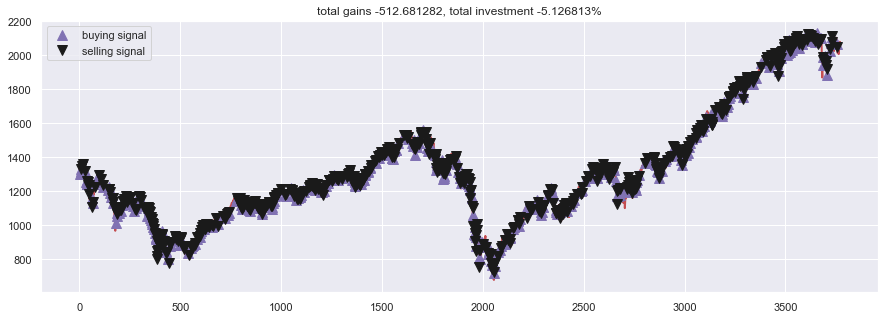

In [22]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()
